<h2>MAE 290 B</h2> 
<h2>Homework Assigment  3</h2>
<p></p>
</h3>Cesar B. Rocha   <crocha@ucsd.edu></h3>

In [1]:
from __future__ import division

import numpy as np
from numpy import pi,sqrt,sin,cos

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 25, 'legend.handlelength'  : 1.25})

%matplotlib inline

import seaborn as sns
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 4.})


# Problem 1

<h3>Create an array of wanumbers, and compute the modified wavenumber
</h3>

In [2]:
# we use non-dimensional variable (k' = k dx)
k = np.linspace(0.001,pi,100)

kp_adv = sin(k)
kp_diff = 2*sin(k/2.)

### Plot advective and diffuse modified wavenumbers

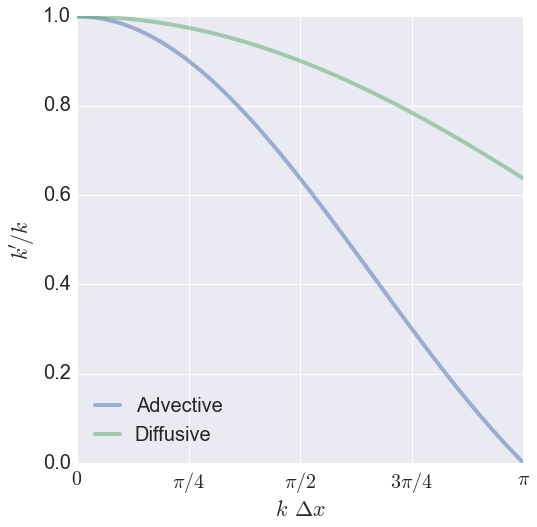

In [3]:
aph = .5

plt.figure(figsize=(8,8))
plt.plot(k,kp_adv/k,label='Advective',alpha=aph)
plt.plot(k,kp_diff/k,label='Diffusive',alpha=aph)
plt.xlabel(r'$k \, \Delta x$')
plt.xlim(0,pi)
plt.xticks([0,pi/4,pi/2.,3*pi/4,pi],[r'$0$',r'$\pi/4$',r'$\pi/2$',\
                                     r'$3 \pi/4$',r'$\pi$'])
plt.ylabel(r"$k'/k$")
plt.legend(loc=3, title = r'')
plt.savefig('figs/mod_wavenum')

In [4]:
from sympy.solvers import solve
from sympy import Symbol

In [5]:
# find the stability criterion for kappa real
x = Symbol('x')
solve(x**3/6. - x**2/2. + x -2.)

[2.51274532661833,
 0.243627336690836 - 2.17170412750084*I,
 0.243627336690836 + 2.17170412750084*I]

### Find and draw the stability region for RK3

In [6]:
kdt_r = np.linspace(-3.,3.,1000)
kdt_i = np.linspace(-3.,3.,1000)
kdt_r,kdt_i = np.meshgrid(kdt_r,kdt_i)
kdt = kdt_r + 1j*kdt_i
poly_k = 1. + kdt  + kdt**2/2 + kdt**3/6
poly_k = np.ma.masked_array(poly_k,np.abs(poly_k)>1.)
poly_k = poly_k*0 + 1.

/Users/crocha/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:2646: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy, subok=True, ndmin=ndmin)


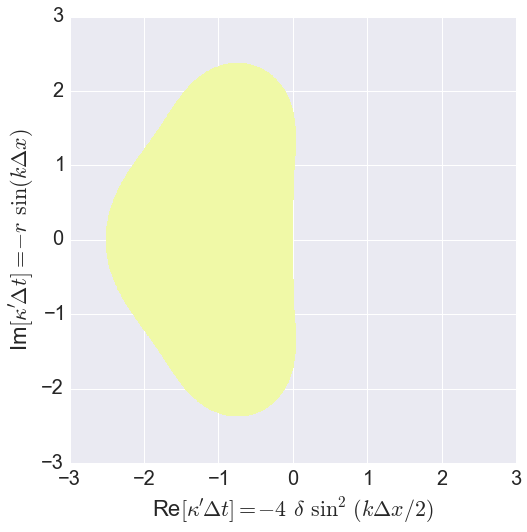

In [7]:
fig1 = plt.figure(figsize=(8,8))
ax1 = fig1.add_subplot(111)
ax1.contourf(kdt_r,kdt_i,poly_k,cmap='Spectral_r')
plt.xlabel(r"Re$[\kappa' \Delta t] = -4 \, \delta \, \sin^2(k \Delta x/2)$")
plt.ylabel(r"Im$[\kappa' \Delta t] = -r \, \sin(k \Delta x)$")
plt.title(r"")
plt.savefig('figs/stability_region_rk3.png')

# Problem 2

### Create initial condition given dx

In [8]:
def initial_T(dx):
    """ Create initial condition given dx """    
    x = np.arange(dx,1.,dx)
    Tini = np.zeros(x.size)
    fini = (x>=.2) & (x<=.5)
    Tini[fini] = sin(20*pi*x[fini])
    
    return Tini

### Plot initial condition

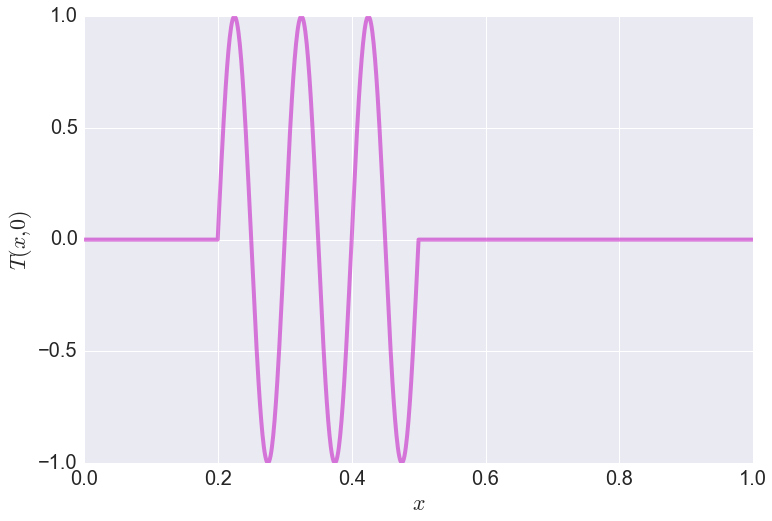

In [9]:
# an example with dx = 0.001
dx = 0.001
x = np.arange(dx,1.,dx)
Tini = initial_T(dx)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(x,Tini,color='m',alpha=.5)
plt.xlabel(r'$x$')
plt.ylabel(r'$T(x,0)$')
plt.savefig('figs/pb2_ic.png')

### Construct a function to evaluate the RHS of the equation

In [10]:
def matrix_M(dx,u,alpha):
    
    """ Create the tridiagonal matrix M 
        given the parameters dx, u, alpha"""
    
    dx2 = dx**2
    beta, xi, gamma = alpha/dx2+u/(2*dx), -2*alpha/dx2, alpha/dx2 -\
    u/(2*dx)

    N = int(1/dx) -1
    M = np.zeros((N,N))
    
    for i in range(N):
        if i == 0: M[0,0],M[0,1] = xi, gamma
        elif i == N-1: M[-1,-2],M[-1,-1] = beta,xi
        else: M[i,i-1],M[i,i],M[i,i+1] = beta,xi,gamma
            
    # Use Orliskin condition if advective (alpha = 0)
    if alpha == 0:
        M[-1,-1] = -u/dx
        M[-1,-2] = u/dx
            
    return M    

def func_adv_diff(T,Tl,Tr,M,dx,u,alpha):
    
    """ Evaluates the RHS of the discretized advection
        diffusion equation given the array of data T, 
        the boundary conditions [Tl,Tr], and matrix M,
        and the parameters dx, u, and alpha 
        
        If pure advective simulation use Tr = 0. A Orliskin
            boundary condition is applied so that the pattern
            exist the finite domain smoothly     """
    
    dx2 = dx**2
    beta, gamma = alpha/dx2+u/(2*dx), alpha/dx2 - u/(2*dx)
    
    Frhs = np.array( np.matrix(M)*np.matrix(T).T )
    Frhs[0] += beta*Tl
    Frhs[-1] += gamma*Tr
    
    return Frhs[:,0]


In [11]:
def my_ode(F,T0,Tl,Tr,t0,tf,dt,dx,u=0.,alpha=1.,scheme='rk3'):
    
    '''
    Integrates dX/dt = F(X,t), where X and F 
    are N-dimensional arrays using RK3. 
    - t0/tf : initial/final time
    - T0 : initial value
    - dt : time step
    
    returns solution (X) and time array (t)
                                        '''
    try:
        N=T0.size
    except AttributeError:
        N=1
    
    t = np.arange(t0,tf+dt,dt)
    X = np.zeros((N,t.size))
    X[:,0] = T0
    
    for i in range(1,t.size):
        if i == 1:
            M = matrix_M(dx,u,alpha)   
        X[:,i] = stepforward(X[:,i-1],F,M,Tl,Tr,t[i-1],dt,dx\
                             ,alpha,u,scheme)

    return X,t

def stepforward(X,F,M,Xl,Xr,t,dt,dx,alpha=1.,u=0.,scheme='rk3'):
    
    '''
    It steps forward a system of first-order ODEs using
    dX/dt = F(X,t), where X and F are N-dimensional
    arrays. The boundary conditions are Xl, Xr
    
    NOTE: nly Explicit Euler (EE) and third-order 
          Runge-Kutta (RK3) schemes are implemented
                                                    '''
    if scheme=='rk3':
        f1 = F(X,Xl,Xr,M,dx,u,alpha)
        a1 = 8/15.
        X1 = X + dt*a1*f1
        f2 = F(X1,Xl,Xr,M,dx,u,alpha)
        a2 = 2/3.
        X2 = X + dt*a2*f2
        f3 = F(X2,Xl,Xr,M,dx,u,alpha)
        Xnew = X + dt/4.*(f1+3.*f3)
    elif scheme=='ee':
        Xnew = X + dt*F(X,Xl,Xr,M,dx,u,alpha)
            
    return Xnew


### First we test the code with a Gaussian initial condition

In [12]:
def initial_gauss(dx,x0=.2,L=.05):
    """ Create guassian condition given dx """    
    x = np.arange(dx,1.,dx)
    Tini = np.exp( -((x-x0)/L)**2 )    
    return Tini

### Advective case: u = 1, $\alpha = 0$

In [13]:
# use a Gaussian initial condition with homogenous bc on the left
dx = 0.001
alpha = 0.
u = 1.
dt = .8*dx*sqrt(3)/np.abs(u)

print "Estimated dt = %10.8f" %(dt)

x = np.arange(dx,1.,dx)
Tl = 0.
Tr = 0.
Tini = initial_gauss(dx)
T,t = my_ode(func_adv_diff,Tini,Tl,Tr,0.,2.,dt,dx,alpha=alpha,u=u)

# append boundary values
T = np.concatenate((np.ones((1,t.size))*Tl,T),axis=0)
T = np.concatenate((T,np.ones((1,t.size))*T[-1,:]),axis=0)
x = np.append(0,x)
x = np.append(x,1.)


Estimated dt = 0.00138564


In [14]:
from JSAnimation.IPython_display import display_animation
from matplotlib import animation

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = plt.axes(xlim=(0,x.max()), ylim=(0,1.2))
line = ax.plot([], [], color='#003366', ls='--', lw=3)[0]
ax.legend(['Computed','Analytical'])

def animate(n):
    line.set_data(x,T[:,n])
    

animation.FuncAnimation(fig, animate,
                        frames=t.size, interval=10)

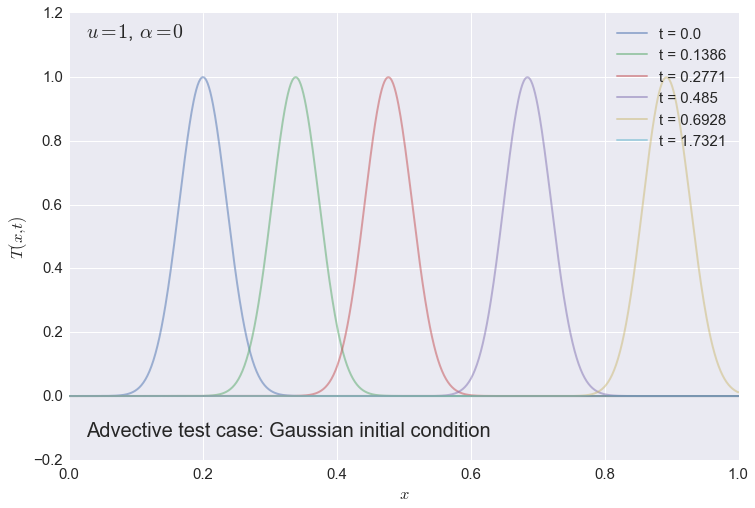

In [1192]:
# plot solution at various times
ndt = np.array([0,100,200,350,500,1250])

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
for i in range(ndt.size):
    ax.plot(x,T[:,ndt[i]],linewidth=2,alpha=.5,\
            label=  't = '+ str(np.round(t[ndt[i]]*10000)/10000))
    plt.ylim(-.2,1.2)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$T(x,t)$')
    lg = plt.legend(loc=1,title= r'')
ax.text(.025,-.125,'Advective test case: Gaussian initial condition',
        fontsize=20)
ax.text(.025,1.125,r'$u = 1$, $\alpha = 0$',fontsize=20)
plt.savefig('figs/gauss_adv')

### Diffusive case: u =0, alpha = 1

In [1197]:
dx = 0.01
N = int(1/dx)
alpha = 1.
u = 0.
dt = .75*(dx**2)*0.628/alpha
x = np.arange(dx,1.,dx)

print "Estimated dt = %10.8f" %(dt)

Tl = 0.
Tr = 0.

Tini = initial_gauss(dx,x0=.5)
T,t = my_ode(func_adv_diff,Tini,Tl,Tr,0.,2.,dt,dx,alpha=1.,u=0)

# append boundary conditions
T = np.concatenate((np.ones((1,t.size))*Tl,T),axis=0)
T = np.concatenate((T,np.ones((1,t.size))*Tr),axis=0)
x = np.append(0,x)
x = np.append(x,1.)

Estimated dt = 0.00004710


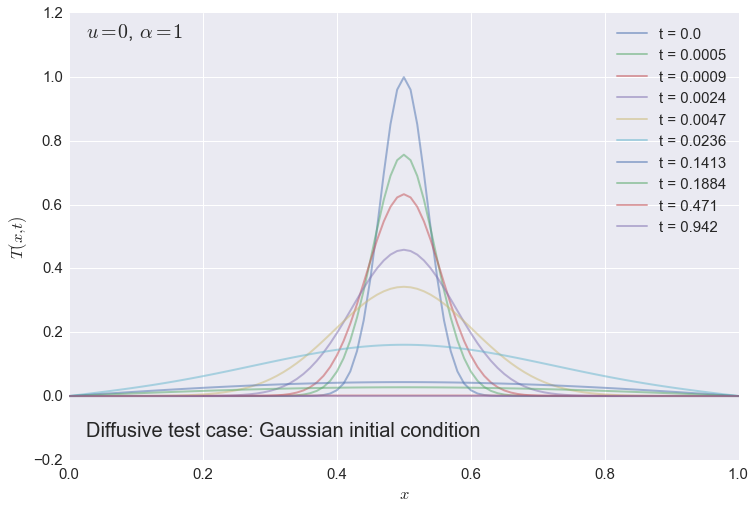

In [1198]:
# plot solution at various times
ndt = np.array([0,10,20,50,100,500,3000,4000,10000,20000])

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
for i in range(ndt.size):
    ax.plot(x,T[:,ndt[i]],linewidth=2,alpha=.5,\
            label=  't = '+ str(np.round(t[ndt[i]]*10000)/10000))
    plt.ylim(-.2,1.2)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$T(x,t)$')
    lg = plt.legend(loc=1,title= r'')
ax.text(.025,-.125,'Diffusive test case: Gaussian initial condition',
        fontsize=20)
ax.text(.025,1.125,r'$u = 0$, $\alpha = 1$',fontsize=20)
plt.savefig('figs/gauss_diff')



### Advective-Diffusive case

In [1200]:
# use a Gaussian initial condition with homogenous bc on the left
dx = 0.01
alpha = .01
u = 1.
dt_adv = .1*dx*sqrt(3)/np.abs(u)
dt_diff = .75*(dx**2)*0.628/alpha

# choose the most restrictive time-step
if dt_adv < dt_diff: dt = dt_adv
else: dt = dt_diff
    
print "Estimated dt = %10.8f" %(dt)
    
x = np.arange(dx,1.,dx)
Tl = 0.
Tr = 0.
Tini = initial_gauss(dx)
T,t = my_ode(func_adv_diff,Tini,Tl,Tr,0.,2.,dt,dx,alpha=alpha,u=u)

# append boundary values
T = np.concatenate((np.ones((1,t.size))*Tl,T),axis=0)
T = np.concatenate((T,np.ones((1,t.size))*T[-1,:]),axis=0)
x = np.append(0,x)
x = np.append(x,1.)

Estimated dt = 0.00173205


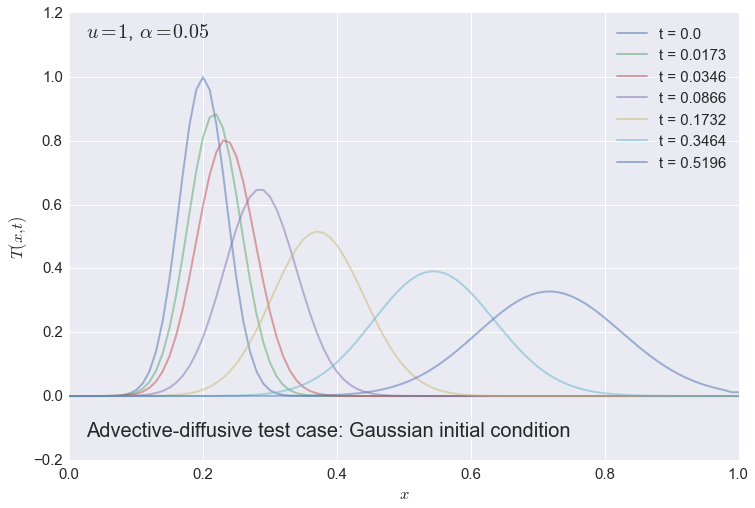

In [1201]:
# plot solution at various times
ndt = np.array([0,10,20,50,100,200,300])

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
for i in range(ndt.size):
    ax.plot(x,T[:,ndt[i]],linewidth=2,alpha=.5,\
            label=  't = '+ str(np.round(t[ndt[i]]*10000)/10000))
    plt.ylim(-.2,1.2)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$T(x,t)$')
    lg = plt.legend(loc=1,title= r'')
ax.text(.025,-.125,'Advective-diffusive test case: Gaussian initial condition',
        fontsize=20)
ax.text(.025,1.125,r'$u = 1$, $\alpha = 0.05$',fontsize=20)
plt.savefig('figs/gauss_adv-diff')

### (a) Advective case: u = 1, $\alpha$ = 0

In [1407]:
dx = 0.001
alpha = 0.
u = 1.
dt = .9*dx*sqrt(3)/np.abs(u)
x = np.arange(dx,1.,dx)
Tl = 1.
Tr = 0.

print "Estimated dt = %10.8f" %(dt)

Tini = initial_T(dx)
T,t = my_ode(func_adv_diff,Tini,Tl,Tr,0.,2.,dt,dx,alpha=alpha,u=u)

# append boundary values
T = np.concatenate((np.ones((1,t.size))*Tl,T),axis=0)
T = np.concatenate((T,np.ones((1,t.size))*T[-1,:]),axis=0)
x = np.append(0,x)
x = np.append(x,1.)


Estimated dt = 0.00155885


In [1408]:
def exact_adv(dx,u,t):
    """ calculate exact solution """    
    x = np.arange(dx,1.,dx)
    Tini = np.zeros(x.size)
    fini = ((x-u*t)>=.2) & ((x-u*t)<=.5)
    Tini[fini] = sin(20*pi*(x[fini]-u*t))
    Tini[x<u*t] = 1.
    
    Tini = np.append(1.,Tini)
    Tini = np.append(Tini,Tini[-1])
    
    return Tini

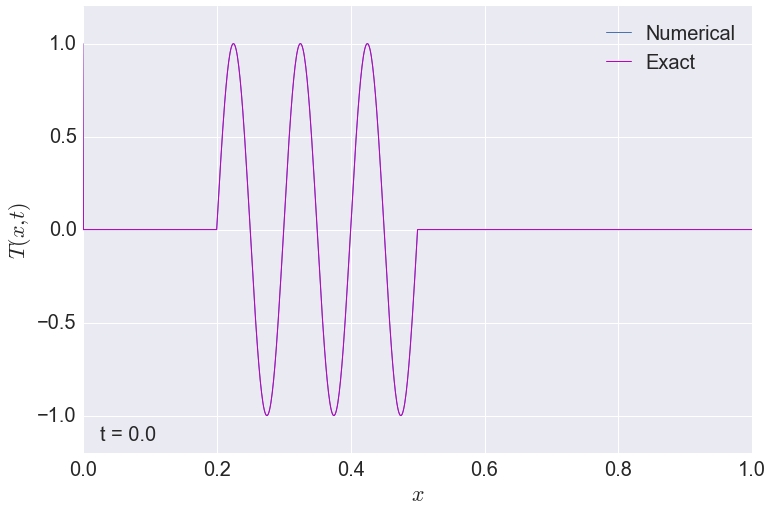

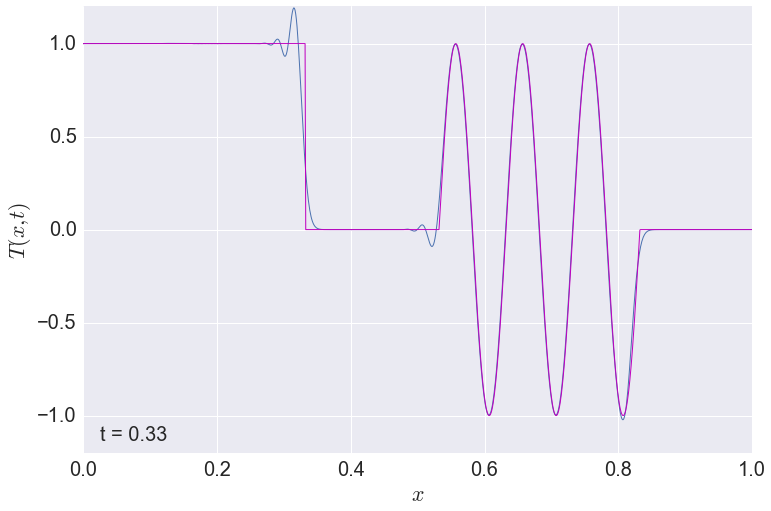

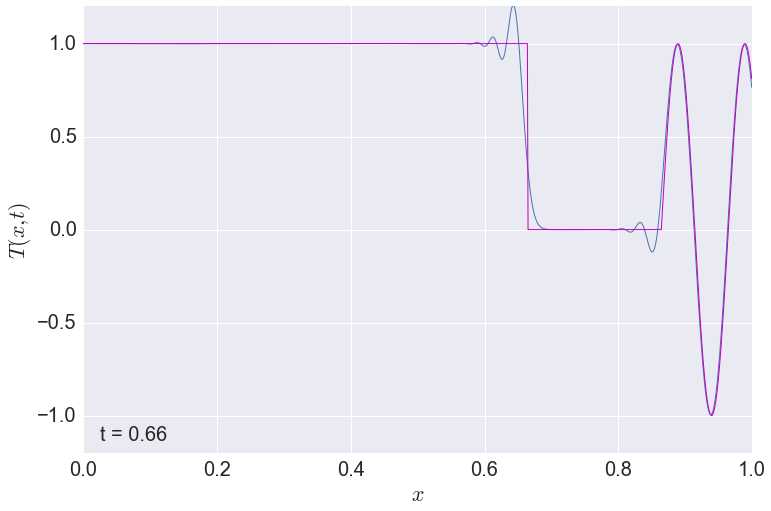

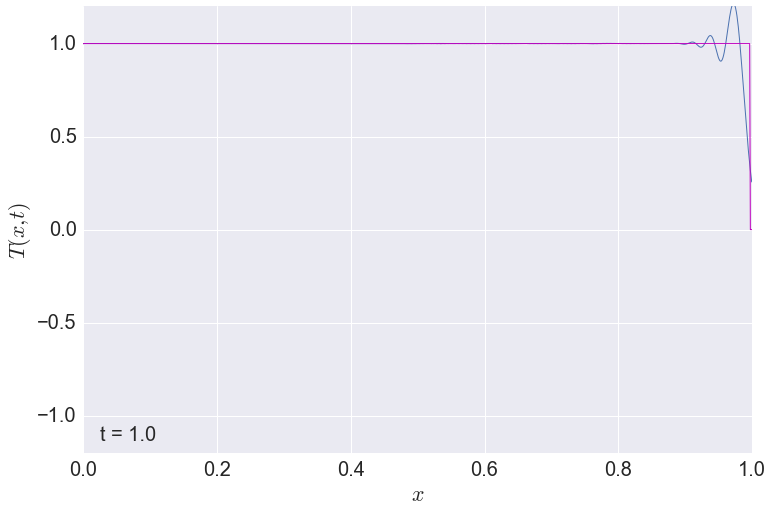

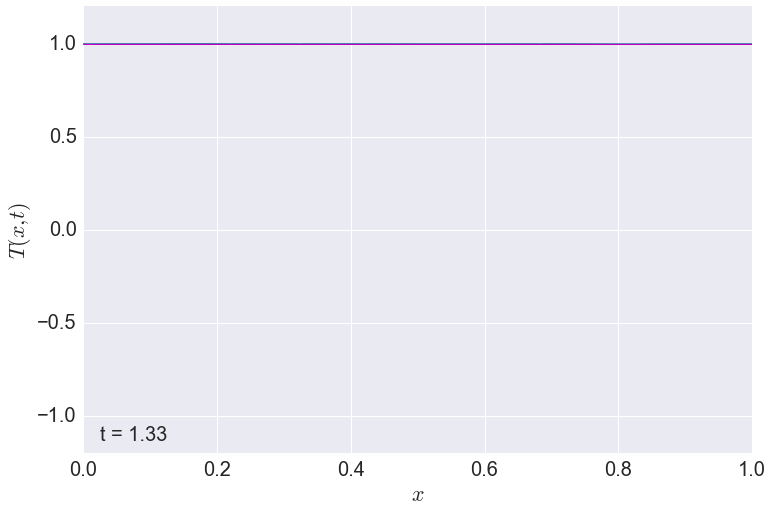

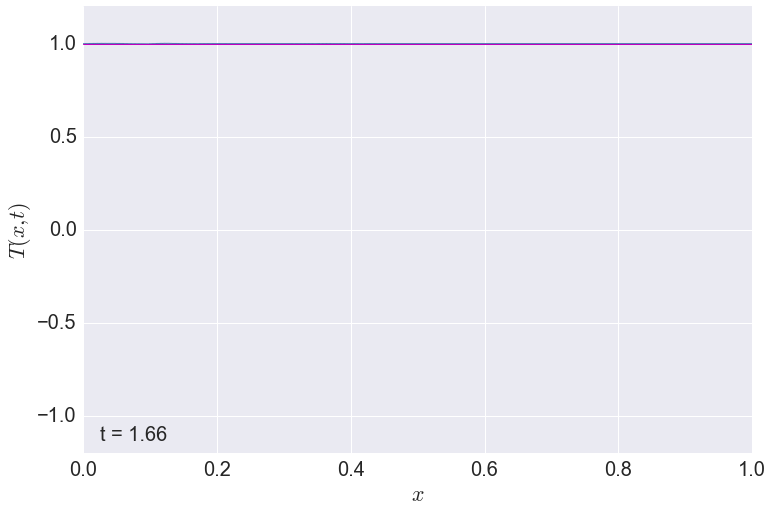

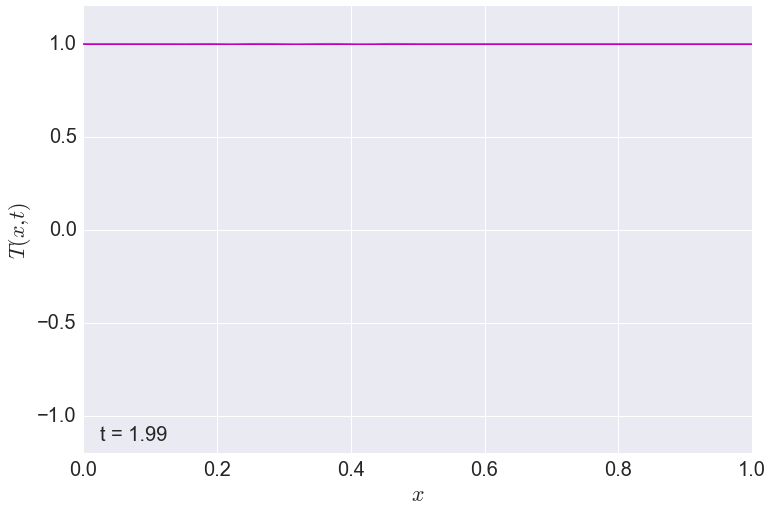

In [1412]:
# plot solution at various times
n = 6
ndt = int(t.size/n)-1

for i in range(n+1):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    if i == 0:
        ax.plot(x,T[:,ndt*(i)],linewidth=1,label='Numerical')
        ax.plot(x,exact_adv(dx,u,t[ndt*i]),linewidth=1,color='m',\
                label='Exact')
        lg = plt.legend(loc=1,title= r'')
    else:
        ax.plot(x,T[:,ndt*(i)],linewidth=1)
        ax.plot(x,exact_adv(dx,u,t[ndt*i]),linewidth=1,color='m')
        
    ax.text(0.025,-1.13,'t = '+ str(np.round(t[ndt*i]*100)/100),\
            fontsize=20)
    plt.ylim(-1.2,1.2)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$T(x,t)$')
    tit = 'figs/pb2_adv_'+str(i)
    plt.savefig(tit)

### (b) Diffusive case u = 0, $\alpha$ = 1

In [1218]:
dx = 0.01
N = int(1/dx)
alpha = 1.
u = 0.
dt = .75*(dx**2)*0.628/alpha
x = np.arange(dx,1.,dx)
Tl = 1.
Tr = 0.

print "Estimated dt = %10.8f" %(dt)

Tini = initial_T(dx)
T,t = my_ode(func_adv_diff,Tini,Tl,Tr,0.,2.,dt,dx,alpha=1.,u=0)

# append boundary conditions
T = np.concatenate((np.ones((1,t.size))*Tl,T),axis=0)
T = np.concatenate((T,np.ones((1,t.size))*Tr),axis=0)
x = np.append(0,x)
x = np.append(x,1.)

Estimated dt = 0.00004710


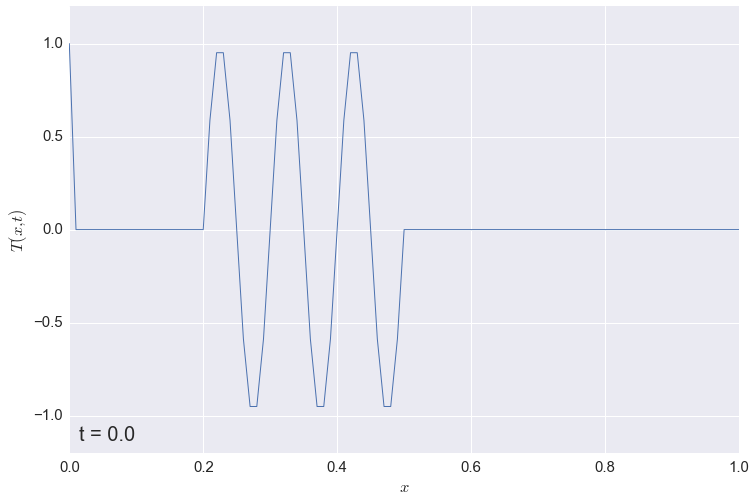

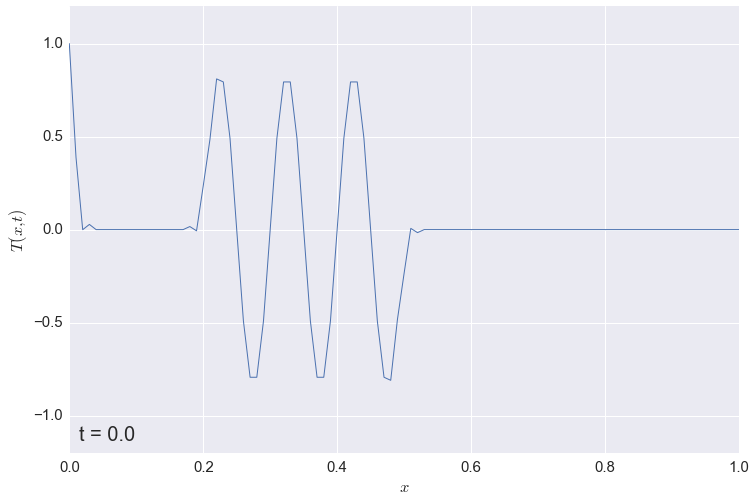

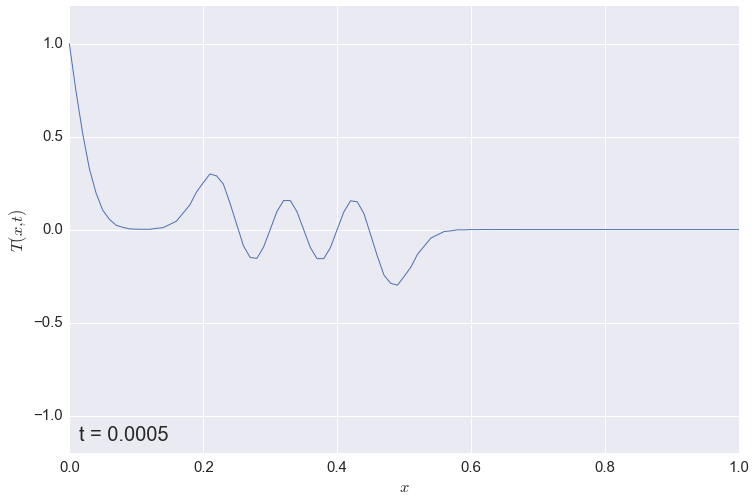

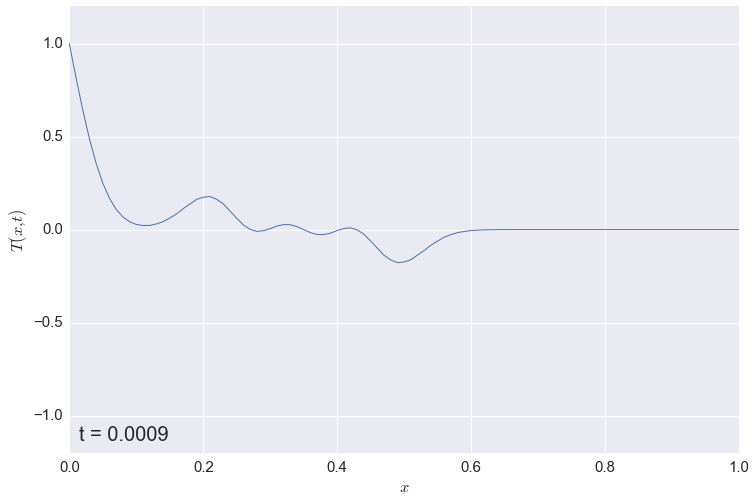

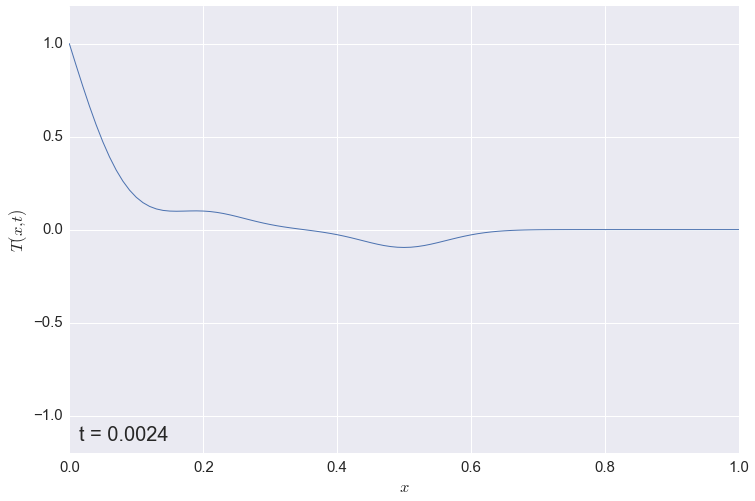

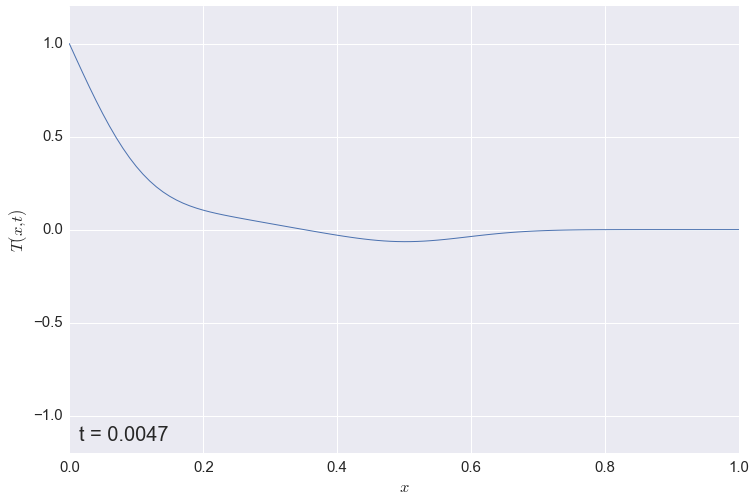

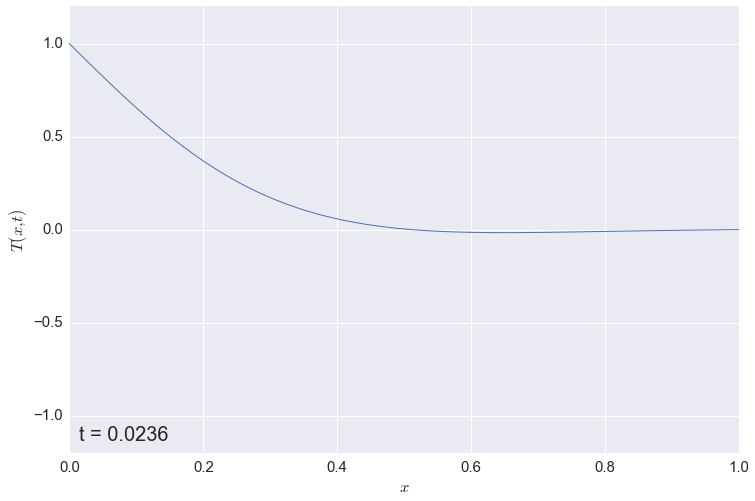

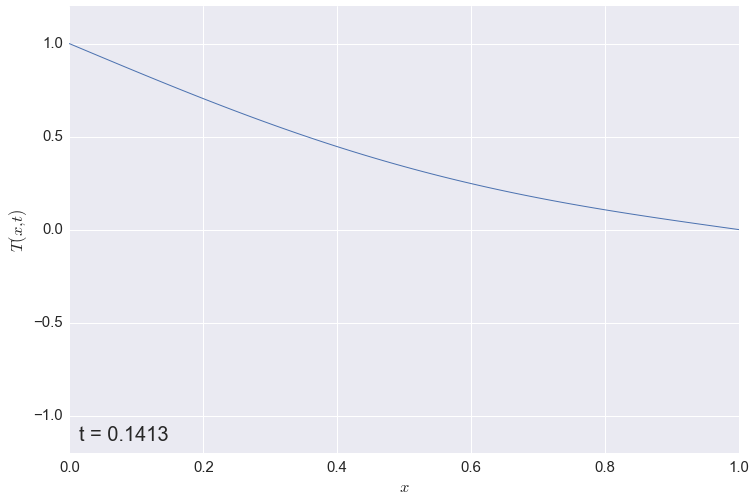

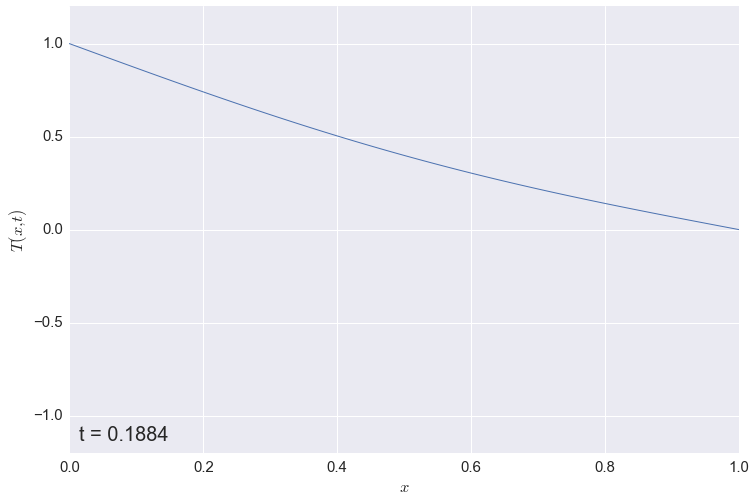

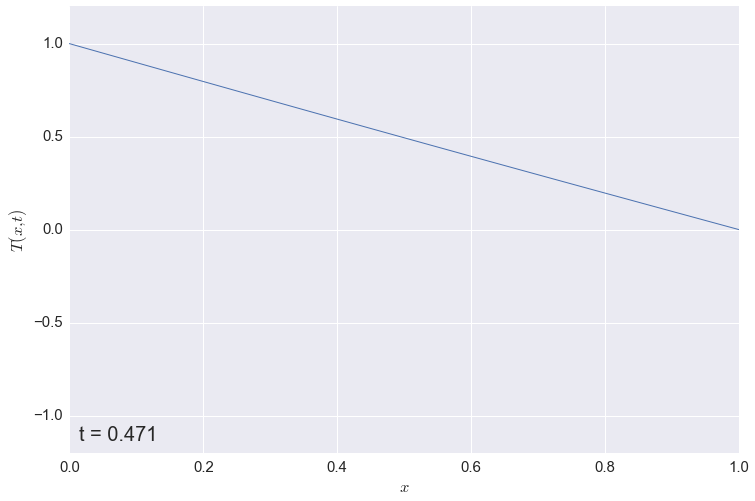

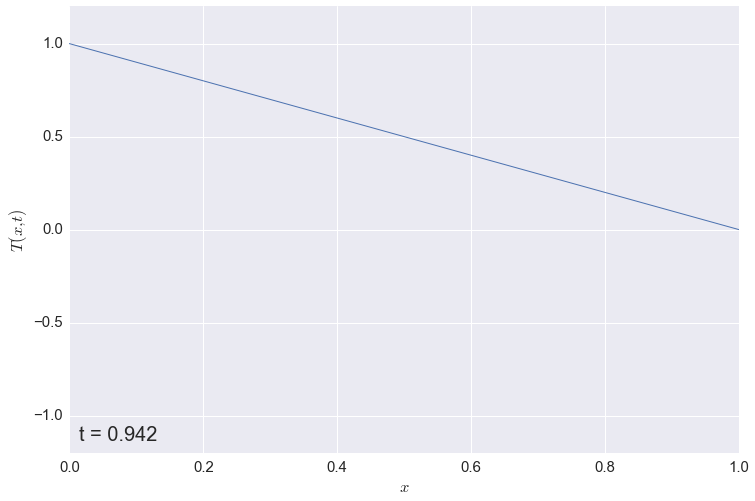

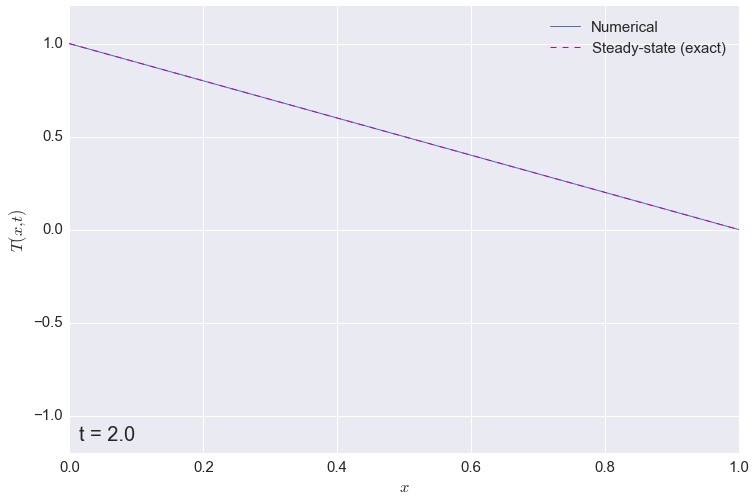

In [1219]:
# plot solution at various times
ndt = np.array([0,1,10,20,50,100,500,3000,4000,10000,20000,t.size-1])

for i in range(ndt.size):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    if i == ndt.size -1:
        ax.plot(x,T[:,ndt[i]],linewidth=1,label='Numerical')
        ax.plot(x,1-x,'--',linewidth=1,color='m'\
                ,label='Steady-state (exact)')
        lg = plt.legend(loc=1,title= r'')
    else:
        ax.plot(x,T[:,ndt[i]],linewidth=1)
        
    ax.text(0.015,-1.13,'t = '+ str(np.round(t[ndt[i]]*10000)/10000),\
            fontsize=20)
    plt.ylim(-1.2,1.2)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$T(x,t)$')
    tit = 'figs/pb2_diff_'+str(i)
    plt.savefig(tit)

# Problem 3

In [1220]:
# evaluate the RHS of the 2D Burgers equation system

# given u,v compute Fu and Fv
def Compute_FuFv(u,v,N=100,nu=0.015):

    # parameters
    h = 1/(N+1)
    h2 = h**2
    h_2 = 2*h
    nuh = nu/h2
    gamma = -4*nuh
    
    Fu,Fv = np.zeros((N,N)), np.zeros((N,N))

    x = np.arange(N+2)*h
    y = np.arange(N+2)*h

    # append boundary conditions
    U,V = np.zeros((N+2,N+2)), np.zeros((N+2,N+2))
    U[1:-1,1:-1],V[1:-1,1:-1] = u,v
    
    U[0,:],U[-1,:] = 0., 0.
    U[:,0],U[:,-1] = sin(2.*pi*x),sin(2.*pi*x)

    V[0,:],V[-1,:] = 1.-y, 1.-y
    V[:,0],V[:,-1] = 1.,0

    # evaluate Fu and Fv
    for i in range(1,N+1):
        for j in range(1,N+1):

            beta_um, beta_up = nuh - U[i,j]/h_2,nuh + U[i,j]/h_2
            beta_vm, beta_vp = nuh - V[i,j]/h_2,nuh + V[i,j]/h_2

            Fu[i-1,j-1] =  beta_um*U[i+1,j] + beta_up*U[i-1,j] + \
                           +  beta_vm*U[i,j+1] + beta_vp*U[i,j-1] + \
                            gamma*U[i,j] 
                    
            Fv[i-1,j-1] =  beta_um*V[i+1,j] + beta_up*V[i-1,j] + \
                           +  beta_vm*V[i,j+1] + beta_vp*V[i,j-1] + \
                            gamma*V[i,j]

    return Fu,Fv

### We then adapt the RK3 functions used previously to march the system forward

In [1258]:
def my_ode(F,u0,v0,t0,tf,dt,N=100):
    
    '''
        Solve two coupled systems of ODE that arises from discretizing
            the 2D (x,y,t) coupled Burgers equation
            
        ---------------------------------------------------------
            F: function that represents the RHS of the systems
            u0,v0 : N by N array of initial conditions
            t0: inital time
            tf: final time
            dt: time step
            N:  number of points in each directions 
        ----------------------------------------------------------
    '''

    ix,jx = u0.shape

    t = np.arange(t0,tf+dt,dt)
    
    U,V = np.zeros((ix,jx,t.size)),np.zeros((ix,jx,t.size))
    U[:,:,0],V[:,:,0] = u0,v0
    
    for i in range(1,t.size):
        U[:,:,i],V[:,:,i] = stepforward(F,U[:,:,i-1],V[:,:,i-1],dt,N=N)

    return U,V,t

def stepforward(F,u,v,dt,N=100):
    
    '''
        Step forward the coupled systems of ODE that arises from discretizing
            the 2D (x,y,t) coupled Burgers equation
            
        Uses RK3 schemme    
            
        ---------------------------------------------------------
            F: function that represents the RHS of the systems
            u,v : N by N array of variables to be stepped forward
            dt: time step
            N:  number of points in each directions 
        ----------------------------------------------------------
      
    '''
    
    a1 = 8/15.
    a2 = 2/3.

    f1u,f1v = F(u,v,N)
    u1,v1 = u + dt*a1*f1u,v + dt*a1*f1v

    f2u,f2v = F(u1,v1,N)
    u2,v2 = u1 + dt*a2*f2v,v1 + dt*a2*f2v

    f3u,f3v = F(u2,v2,N)

    unew,vnew = u + dt/4.*(f1u+3.*f3u), v + dt/4.*(f1v+3.*f3v)

    return unew,vnew

In [1392]:
# number of points and initial condition
N = 101
u0,v0 = np.zeros((N,N)), np.zeros((N,N))

# compute dt based on diffusive time scale 
dx = 1./(N+1)
nu = 0.015
dt = .5*(dx**2)*0.628/nu

u,v,t = my_ode(Compute_FuFv,u0,v0,t0=0.,tf=2.,dt=dt,N=N)


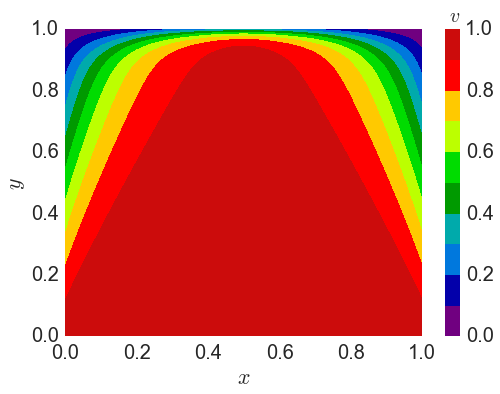

In [1393]:
x = np.linspace(0.,1.,N)
y = np.linspace(0.,1.,N)

plt.figure
plt.contourf(x,y,v[:,:,-1].T,10,cmap='spectral')
cb = plt.colorbar()
cb.ax.text(.25,1.025,r'$v$',rotation=0,fontsize=20)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.savefig('figs/pb3_v')

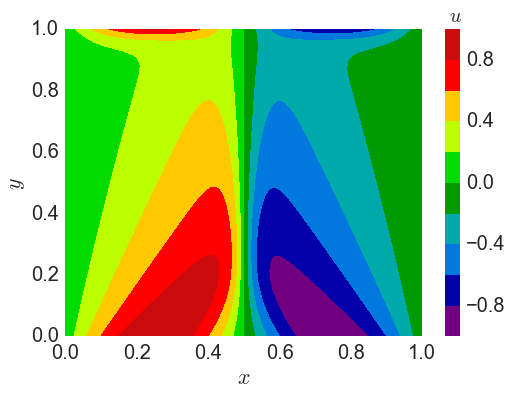

In [1394]:
plt.contourf(x,y,u[:,:,-1].T,10,cmap='spectral')
cb = plt.colorbar()
cb.ax.text(.25,1.025,r'$u$',rotation=0,fontsize=20)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.savefig('figs/pb3_u')

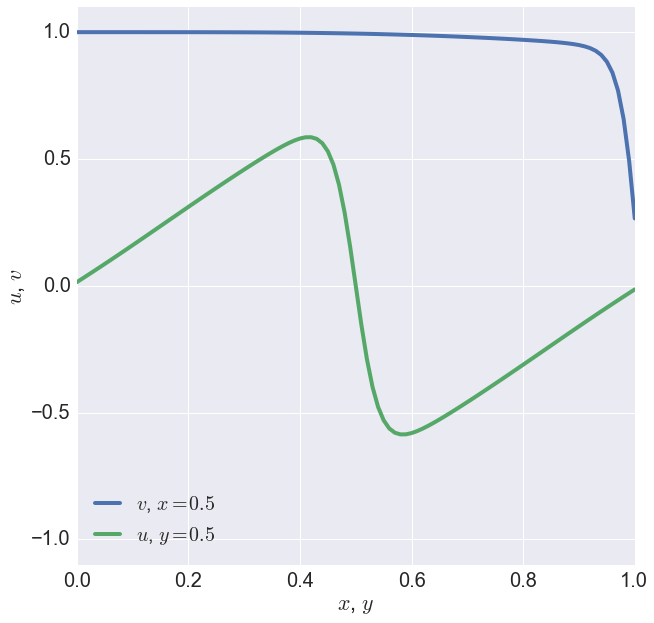

In [1395]:
plt.figure(figsize=(10,10))
plt.plot(y,v[N/2,:,-1],label=r'$v$, $x=0.5$')
plt.plot(x,u[:,N/2,-1],label=r'$u$, $y=0.5$')
plt.xlabel(r'$x$, $y$')
plt.ylabel(r'$u$, $v$')
plt.ylim(-1.1,1.1)
lg = plt.legend(loc=3,title= r'')
plt.savefig('figs/pb3_uv_xy_fixed')

In [1403]:
# test the influence of the grid-spacing
N = 21
u0,v0 = np.zeros((N,N)), np.zeros((N,N))
#u0,v0 = np.random.randn(N,N), np.random.randn(N,N)

# compute dt based on diffusive time scale 
dx = 1./(N+1)
nu = 0.015
dt = .5*(dx**2)*0.628/nu

u,v,t = my_ode(Compute_FuFv,u0,v0,t0=0.,tf=10.,dt=dt,N=N)

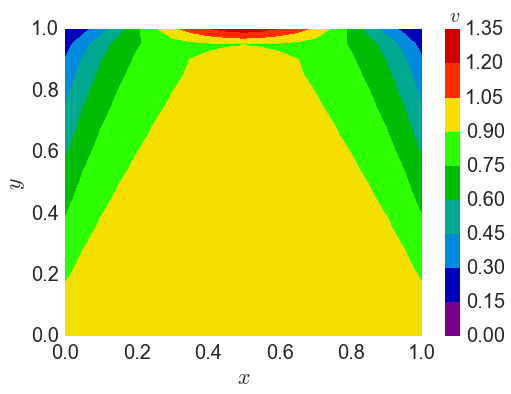

In [1404]:
x = np.linspace(0.,1.,N)
y = np.linspace(0.,1.,N)

plt.figure
plt.contourf(x,y,v[:,:,-1].T,10,cmap='spectral')
cb = plt.colorbar()
cb.ax.text(.25,1.025,r'$v$',rotation=0,fontsize=20)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.savefig('figs/pb3_v_201')

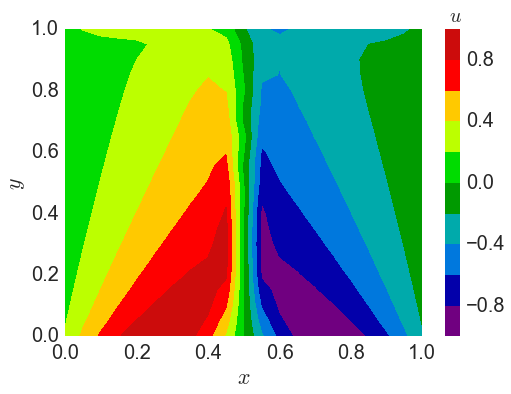

In [1401]:
plt.figure
plt.contourf(x,y,u[:,:,-1].T,10,cmap='spectral')
cb = plt.colorbar()
cb.ax.text(.25,1.025,r'$u$',rotation=0,fontsize=20)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.savefig('figs/pb3_u_201')

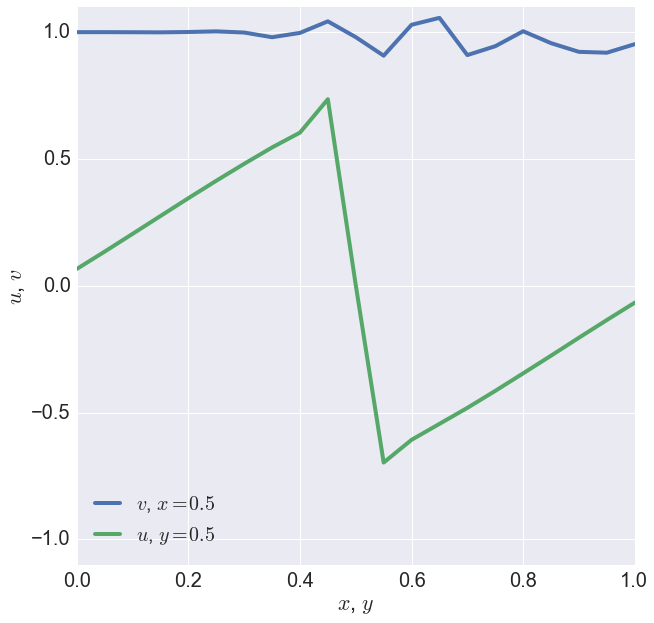

In [1402]:
plt.figure(figsize=(10,10))
plt.plot(y,v[N/2,:,-1],label=r'$v$, $x=0.5$')
plt.plot(x,u[:,N/2,-1],label=r'$u$, $y=0.5$')
plt.xlabel(r'$x$, $y$')
plt.ylabel(r'$u$, $v$')
plt.ylim(-1.1,1.1)
lg = plt.legend(loc=3,title= r'')
plt.savefig('figs/pb3_uv_xy_fixed_201')

In [1248]:
from IPython.core.display import HTML
css_file = 'numericalmoocstyle.css'
HTML(open(css_file, "r").read())

## 